# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 3</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp
import sklearn as sk
import joblib

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV, cross_validate, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier



In [2]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()
poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 3. Clasificación

### a. Construcción del target

La idea de este Trabajo es poder predecir el precio de una propiedad.  
El tipo de precio puede ser alto, medio o bajo, y para evaluar el mismo vamos a generarnos una nueva variable en el dataset, que sea el precio por metro cuadrado.

In [3]:
viviendas_caba_train['pxm2'] = viviendas_caba_train.property_price / viviendas_caba_train.property_surface_total
viviendas_caba_test['pxm2'] = viviendas_caba_test.property_price / viviendas_caba_test.property_surface_total
viviendas_caba_train.head()

,start_date,end_date,latitud,longitud,barrio,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,geometry,pxm2
0,2021-12-15,2021-12-25,-34.555049,-58.490513,Saavedra,Departamento,2.0,1.0,58.0,49.0,167113.0,Departamento - Saavedra,POINT (-58.4905135 -34.5550487),2881.258621
1,2021-05-20,2021-06-05,-34.546991,-58.478553,Saavedra,Departamento,2.0,1.0,48.0,44.0,129000.0,Departamento - Saavedra,POINT (-58.4785532 -34.546991),2687.500000
2,2021-03-20,2021-04-16,-34.570842,-58.491805,Villa Urquiza,Departamento,2.0,1.0,62.0,58.0,124600.0,Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...,POINT (-58.4918048 -34.5708421),2009.677419
3,2021-07-17,2021-10-16,-34.589251,-58.402106,Recoleta,Departamento,3.0,2.0,60.0,60.0,196000.0,Excelente 3 ambientes en venta en Barrio Recoleta,POINT (-58.4021058 -34.5892511),3266.666667
4,2021-07-02,2022-02-09,-34.626290,-58.437632,Caballito,Departamento,3.0,2.0,67.0,61.0,235000.0,VENTA DEPARTAMENTO 3 AMB. EN CABALLITO,POINT (-58.4376325 -34.6262899),3507.462687


Para evaluar el tipo de precio, procedemos a subclasificar el precio por metro cuadrado segun las cantidades de observaciones.  
Primero lo hacemos con cantidad igual de observaciones y luego dividimos en cuartiles , el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.  
Finalmente selecionaremos cada tipo de propiedad y haremos las mismas divisiones mencionadas.

In [4]:
labels=["Bajo","Medio","Alto"]

viviendas_caba_train["tipo_precio_igual_frec"], viviendas_caba_train_bins_igual_frec = pd.qcut(viviendas_caba_train["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train["tipo_precio_cuartiles"], viviendas_caba_train_bins_cuartiles = pd.qcut(viviendas_caba_train["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
viviendas_agrupada_tipo_precio_igual_frec = viviendas_caba_train.groupby(["tipo_precio_igual_frec"]).count()
viviendas_agrupada_tipo_precio_cuartiles = viviendas_caba_train.groupby(["tipo_precio_cuartiles"]).count()

viviendas_caba_train_depto = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Departamento"].copy()
viviendas_caba_train_depto["tipo_precio_igual_frec"], viviendas_caba_train_depto_bins_igual_frec = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train_depto["tipo_precio_cuartiles"], viviendas_caba_train_depto_bins_cuartiles = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
deptos_agrupado_tipo_precio_igual_frec = viviendas_caba_train_depto.groupby(["tipo_precio_igual_frec"]).count()
deptos_agrupado_tipo_precio_cuartiles = viviendas_caba_train_depto.groupby(["tipo_precio_cuartiles"]).count()

viviendas_caba_train_ph = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"].copy()
viviendas_caba_train_ph["tipo_precio_igual_frec"], viviendas_caba_train_ph_bins_igual_frec = pd.qcut(viviendas_caba_train_ph["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train_ph["tipo_precio_cuartiles"], viviendas_caba_train_ph_bins_cuartiles = pd.qcut(viviendas_caba_train_ph["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
ph_agrupado_tipo_precio_igual_frec = viviendas_caba_train_ph.groupby(["tipo_precio_igual_frec"]).count()
ph_agrupado_tipo_precio_cuartiles = viviendas_caba_train_ph.groupby(["tipo_precio_cuartiles"]).count()

viviendas_caba_train_casa = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Casa"].copy()
viviendas_caba_train_casa["tipo_precio_igual_frec"], viviendas_caba_train_casa_bins_igual_frec = pd.qcut(viviendas_caba_train_casa["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train_casa["tipo_precio_cuartiles"], viviendas_caba_train_casa_bins_cuartiles = pd.qcut(viviendas_caba_train_casa["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
casas_agrupada_tipo_precio_igual_frec = viviendas_caba_train_casa.groupby(["tipo_precio_igual_frec"]).count()
casas_agrupada_tipo_precio_cuartiles = viviendas_caba_train_casa.groupby(["tipo_precio_cuartiles"]).count()



Y ahora graficamos segun los intervalos obtenidos

[Text(0.5, 1.0, 'Intervalos de viviendas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

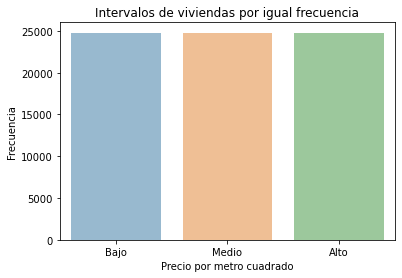

In [5]:
eje_x = viviendas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de viviendas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de viviendas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

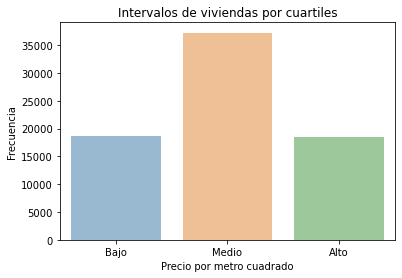

In [6]:
eje_x = viviendas_agrupada_tipo_precio_cuartiles.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de viviendas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

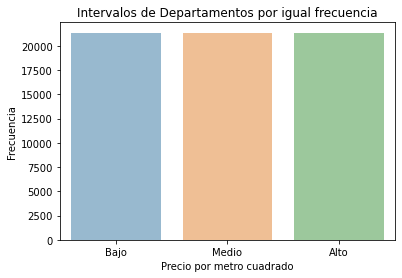

In [7]:
eje_x = deptos_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = deptos_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Departamentos por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

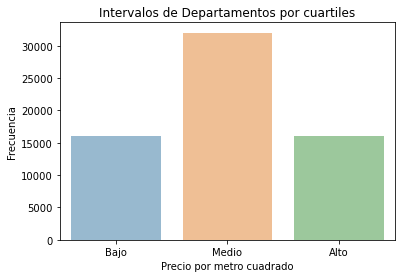

In [8]:
eje_x = deptos_agrupado_tipo_precio_cuartiles.index.tolist()
eje_y = deptos_agrupado_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de Departamentos por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de PH por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

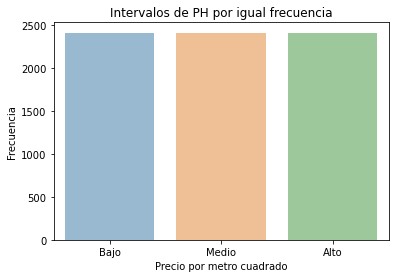

In [9]:
eje_x = ph_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = ph_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de PH por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')


[Text(0.5, 1.0, 'Intervalos de PH por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

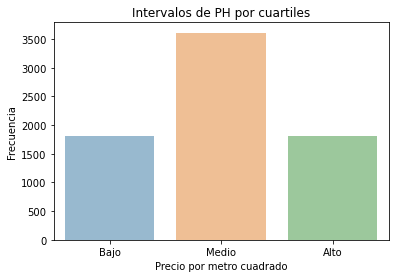

In [10]:
eje_x = ph_agrupado_tipo_precio_cuartiles.index.tolist()
eje_y = ph_agrupado_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de PH por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Casas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

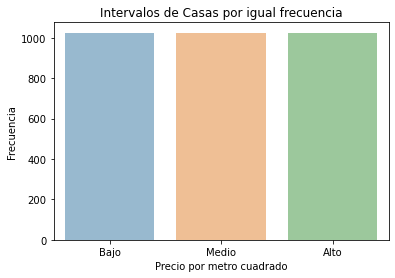

In [11]:
eje_x = casas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = casas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Casas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')



[Text(0.5, 1.0, 'Intervalos de Casas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

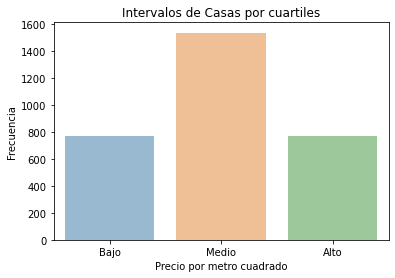

In [12]:
eje_x = casas_agrupada_tipo_precio_cuartiles.index.tolist()
eje_y = casas_agrupada_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de Casas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

Para darnos una idea del target, vamos a mostrar la distribución del precio de las viviendas de todo el dataset.


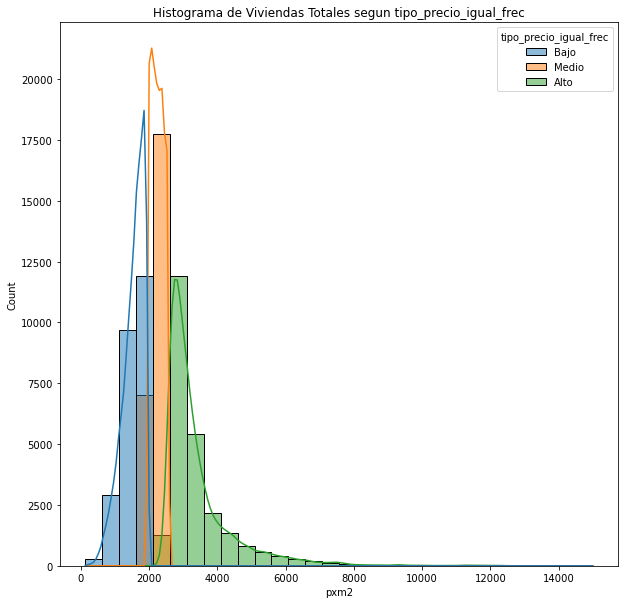

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Viviendas Totales segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

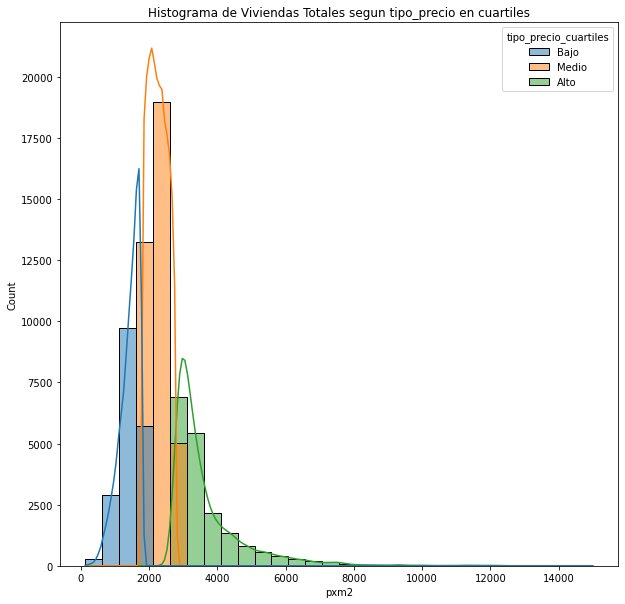

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Viviendas Totales segun tipo_precio en cuartiles')
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

Ahora vamos a hacer lo mismo para cada tipo de propiedad

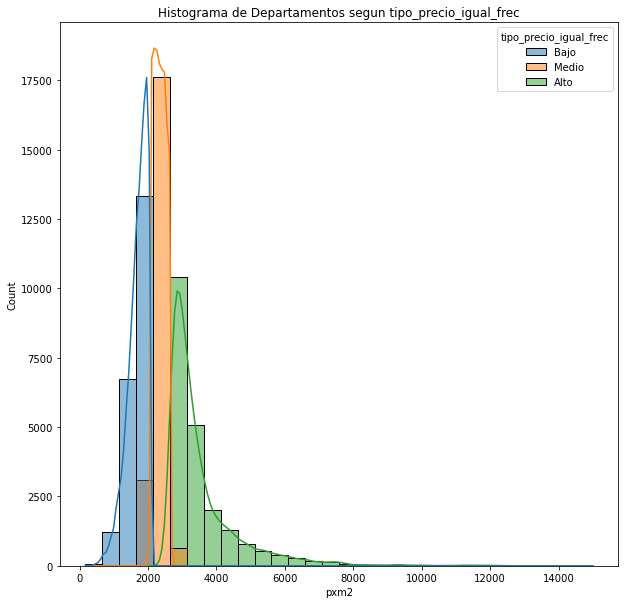

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Departamentos segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

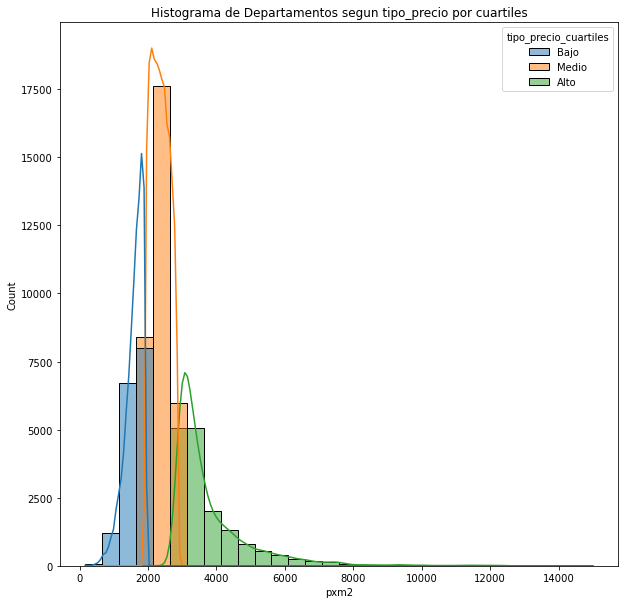

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Departamentos segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

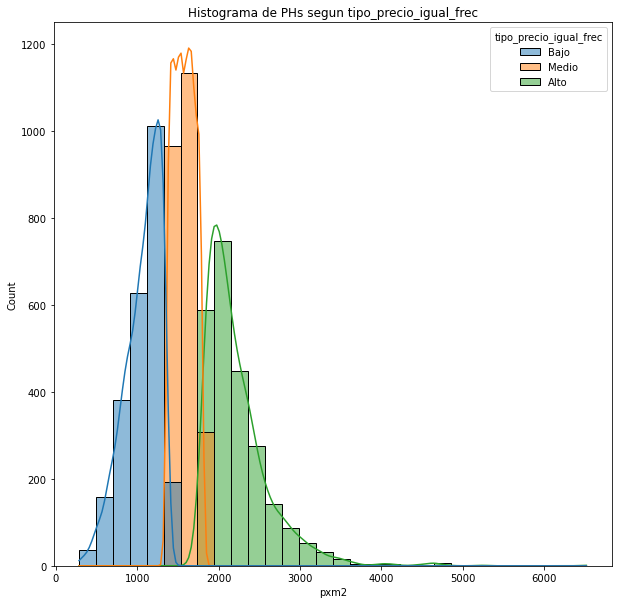

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de PHs segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

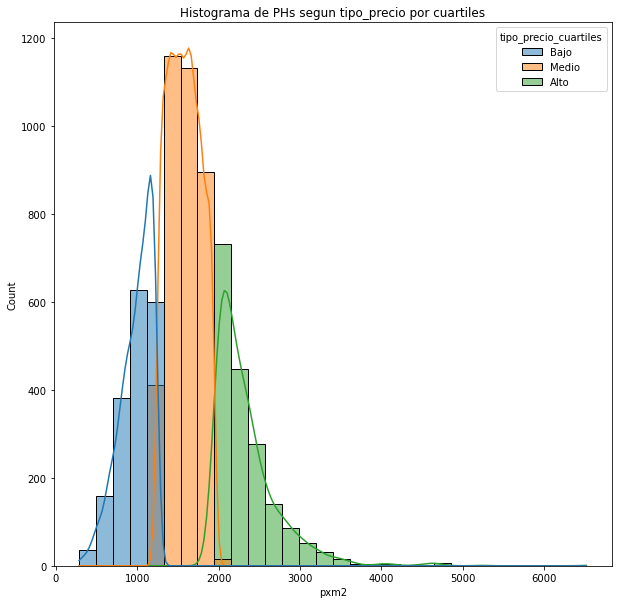

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de PHs segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

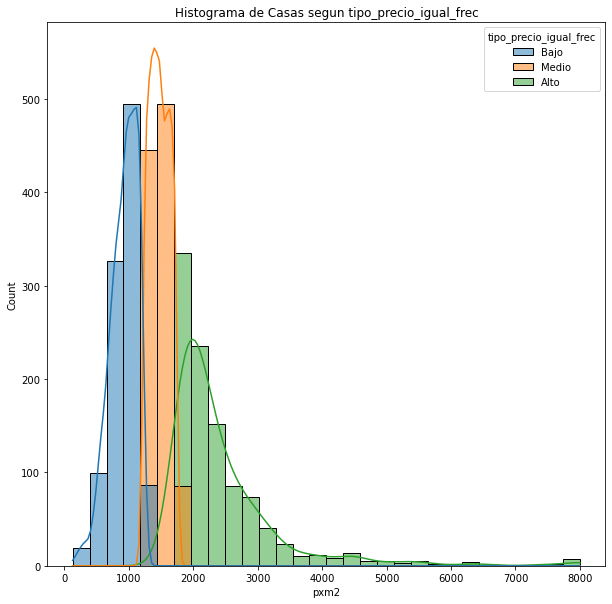

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Casas segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

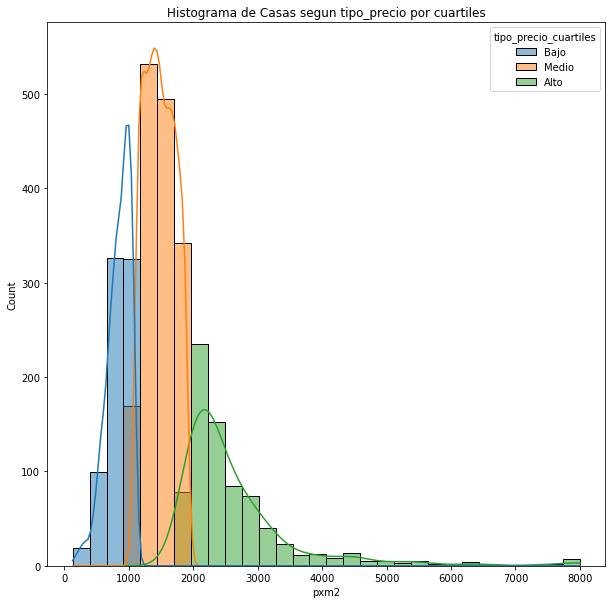

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Casas segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

De los graficos anteriores podemos concluir:
+ Hay muchos mas Departamentos que Casas o PHs, por lo cual vamos a predecir teniendo en cuenta el tipo de propiedad.
+ Vemos que para todo tipo de propiedad, se agrupan muchas propiedades alrededor de los 1600 U$S/m2
+ Por lo anterior, decidimos utilizar el binning por cuartiles, ya que es esperable que de agarrar una propiedad, esta sea de tipo de precio Medio

Procedemos a agregar estos datos en los datasets de entrenamiento. Para el dataset de test, vamos a dividir los mismos segun los bins 

In [21]:
viviendas_caba_train.loc[viviendas_caba_train_depto.index,"tipo_precio"] = viviendas_caba_train_depto["tipo_precio_cuartiles"] 
viviendas_caba_train.loc[viviendas_caba_train_ph.index,"tipo_precio"] = viviendas_caba_train_ph["tipo_precio_cuartiles"] 
viviendas_caba_train.loc[viviendas_caba_train_casa.index,"tipo_precio"] = viviendas_caba_train_casa["tipo_precio_cuartiles"] 

lista_bins_depto = list(viviendas_caba_train_depto_bins_cuartiles)
lista_bins_depto[0] = 0
lista_bins_depto[3] = np.Infinity

lista_bins_ph = list(viviendas_caba_train_ph_bins_cuartiles)
lista_bins_ph[0] = 0
lista_bins_ph[3] = np.Infinity


lista_bins_casa = list(viviendas_caba_train_casa_bins_cuartiles)
lista_bins_casa[0] = 0
lista_bins_casa[3] = np.Infinity


viviendas_caba_test_depto = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="Departamento"].copy()
viviendas_caba_test_depto["tipo_precio"] = pd.cut(viviendas_caba_test_depto["pxm2"], bins=lista_bins_depto, labels=labels)

viviendas_caba_test_ph = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="PH"].copy()
viviendas_caba_test_ph["tipo_precio"] = pd.cut(viviendas_caba_test_ph["pxm2"], bins=lista_bins_ph, labels=labels)

viviendas_caba_test_casa = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="Casa"].copy()
viviendas_caba_test_casa["tipo_precio"] = pd.cut(viviendas_caba_test_casa["pxm2"], bins=lista_bins_casa, labels=labels)

viviendas_caba_test.loc[viviendas_caba_test_depto.index,"tipo_precio"] = viviendas_caba_test_depto["tipo_precio"] 
viviendas_caba_test.loc[viviendas_caba_test_ph.index,"tipo_precio"] = viviendas_caba_test_ph["tipo_precio"] 
viviendas_caba_test.loc[viviendas_caba_test_casa.index,"tipo_precio"] = viviendas_caba_test_casa["tipo_precio"] 



viviendas_caba_train = viviendas_caba_train.drop(columns=['tipo_precio_igual_frec', 'tipo_precio_cuartiles'], axis = 0, inplace=False).copy()



Ahora vamos a ver como se distribuyen las propiedades segun su tipo de precio en CABA.

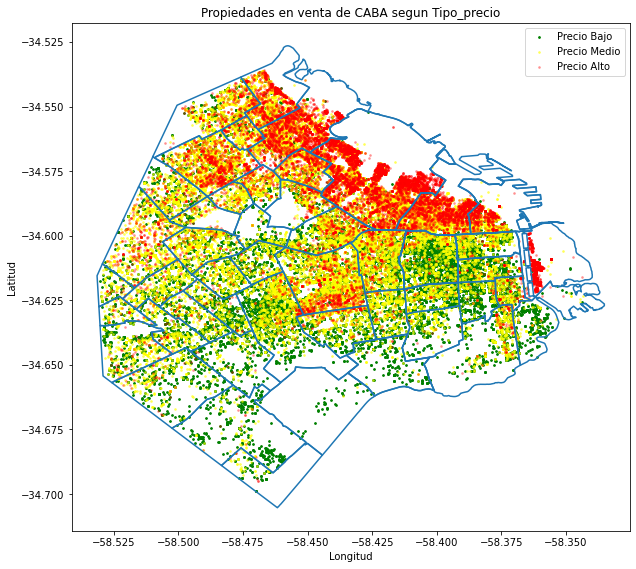

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Propiedades en venta de CABA segun Tipo_precio')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
poly.boundary.plot(ax=ax) #CABA
viviendas_caba_train_bajo = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Bajo']
viviendas_caba_train_medio = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Medio']
viviendas_caba_train_alto = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Alto']
puntos_precio_bajo = gp.GeoDataFrame(viviendas_caba_train_bajo, geometry=gp.points_from_xy(viviendas_caba_train_bajo.longitud,viviendas_caba_train_bajo.latitud)) 
puntos_precio_medio = gp.GeoDataFrame(viviendas_caba_train_medio, geometry=gp.points_from_xy(viviendas_caba_train_medio.longitud,viviendas_caba_train_medio.latitud)) 
puntos_precio_alto = gp.GeoDataFrame(viviendas_caba_train_alto, geometry=gp.points_from_xy(viviendas_caba_train_alto.longitud,viviendas_caba_train_alto.latitud)) 
puntos_precio_bajo.plot(ax=ax,markersize=3, label = 'Precio Bajo', color="green")
puntos_precio_medio.plot(ax=ax,markersize=3, label = 'Precio Medio', color="yellow", alpha = 0.5)
puntos_precio_alto.plot(ax=ax,markersize=3,label = 'Precio Alto', color="red", alpha=0.3)
plt.legend()

Se puede observar que en los barrios pertenecientes a la zona norte tienen mucha mas densidad de propiedades, lo cual tiene sentido dado que constantemente se esta construyendo en esos lugares.  
A su vez, en la zona meridional y sur hay menos propiedades en venta pero a mejor precio.  

## b. Entrenamiento y predicción

Vamos a entrenar modelos para intentar predecir el tipo de precio de un set de propiedades y tambien vamos corroborar la eficiencia de los mismos.  
Antes de ello, vamos a hacer una serie de transformaciones de los dataset.

In [23]:
ds_modelos = viviendas_caba_train.copy()
columnas_train = ['start_date','end_date','property_price','property_title','geometry','pxm2']
ds_modelos['property_rooms'] = ds_modelos['property_rooms'].astype(int)
ds_modelos['property_bedrooms'] = ds_modelos['property_bedrooms'].astype(int)
ds_modelos['property_surface_total'] = ds_modelos['property_surface_total'].astype(int)
ds_modelos['property_surface_covered'] = ds_modelos['property_surface_covered'].astype(int)
ds_modelos = ds_modelos.drop(columns=columnas_train, axis='columns', inplace=False).copy()

Corroboramos que la distribución de clases en los datasets sea la misma que la de la alternativa elegida en el punto 3.a).

In [24]:
ds_modelos['tipo_precio'].value_counts(normalize=True)*100

Medio    50.011440
Bajo     25.008412
Alto     24.980149
Name: tipo_precio, dtype: float64

In [25]:
viviendas_caba_test['tipo_precio'].value_counts(normalize=True)*100

Medio    49.736219
Bajo     25.328381
Alto     24.935401
Name: tipo_precio, dtype: float64

In [26]:
columnas_test = ['start_date','end_date','property_price','property_title','pxm2']
viviendas_caba_test = viviendas_caba_test.drop(columns=columnas_test, axis='columns', inplace=False).copy()


A los fines de poder utilizar el arbol de decision, vamos a sacar del dataset de test aquellas filas con valores NaN.

In [27]:
ds_modelos = pd.get_dummies(ds_modelos, columns=['property_type', 'barrio'])
viviendas_caba_test = pd.get_dummies(viviendas_caba_test, columns=['property_type', 'barrio'])
viviendas_caba_test['barrio_Catalinas'] = 0 #Porque no hay ninguna propiedad en el barrio de Catalinas en el dataset de test

columnas = ds_modelos.columns.tolist()
ds_modelos = ds_modelos[columnas]
viviendas_caba_test = viviendas_caba_test[columnas]

y_train = ds_modelos['tipo_precio'].copy()
y_test = viviendas_caba_test['tipo_precio'].copy()
x_train = ds_modelos.drop(columns=['tipo_precio'], axis='columns', inplace=False).copy()
x_test = viviendas_caba_test.drop(columns=['tipo_precio'], axis='columns', inplace=False).copy()

### Modelo 1: Arbol de decisión

Los arboles de decision basan sus predicciones en funcion de nodos, los cuales estan basados en todos los atributos del dataset.  
A modo de introducción, vamos a hacer una prediccion con un arbol de decision que tenga los parametros por default.

In [28]:
arbol_default = DecisionTreeClassifier(random_state= 42)
arbol_default.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Vamos a probarlo con el dataset de train y el dataset de test, utilizando como metrica la F1 Score, la cual relaciona tanto Precision como Recall.

              precision    recall  f1-score   support

        Alto       0.97      0.99      0.98     18561
        Bajo       0.97      0.99      0.98     18582
       Medio       0.99      0.97      0.98     37160

    accuracy                           0.98     74303
   macro avg       0.97      0.98      0.98     74303
weighted avg       0.98      0.98      0.98     74303

F1-Score: 0.9782377678296538


Text(33.0, 0.5, 'Realidad')

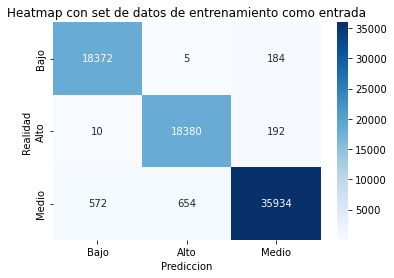

In [29]:
arbol_default.fit(x_train,y_train)
y_pred_train = arbol_default.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

              precision    recall  f1-score   support

        Alto       0.69      0.71      0.70      4632
        Bajo       0.68      0.69      0.68      4705
       Medio       0.72      0.71      0.72      9239

    accuracy                           0.70     18576
   macro avg       0.70      0.70      0.70     18576
weighted avg       0.71      0.70      0.71     18576

F1-Score: 0.7050744790547199


Text(33.0, 0.5, 'Realidad')

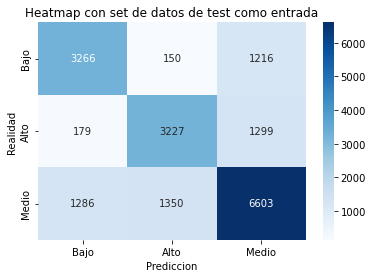

In [30]:
y_pred_test = arbol_default.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Vemos que para el dataset de test, nos da una metrica F1 de 0.67. Claramente podemos observar que se overfittea cuando contrastamos con el dataset de train, pero que no es el caso para el dataset de test.  
Observamos ademas que todas las clases tienen metricas similares. La clase Medio tiene mejores metricas, estimamos que esto se debe a la cantidad de muestras.

Ahora a buscar la mejor combinacion de hiperparametros utilizando K-fold Cross Validation y buscando los mismos con Random Search.  
Por defecto, vamos a dejar la cantidad de folds en 5, luego veremos si podemos mejorar la busqueda de parametros utilizando Grid Search.  
Los hiperparametros del arbol de decision a maximizar son:
+ Criterio: Es el parametro para medir la calidad de la clasificacion. Vamos a hacer que se decida entre Gini o Entropy porque Log Loss no lo conocemos.
+ Splitter: Es el parametro que define la forma de seleccionar categorias de nodos. Vamos a dejarlo por defecto en Best.
+ Max Depth: Es el parametro que, si se lo define, limita la profundidad del arbol. Por defecto deja que el arbol se extienda hasta que sus hojas sean puras, pero esto claramente puede generar un arbol muy grande innecesariamente.
+ Min Samples Split: Es el parametro que define el numero minimo de muestras necesarias para distinguir un nodo interno. Vamos a hacer que pruebe entre valores de 1 a 100.
+ Min Samples Leaf: Es el parametro qe define la minima cantidad de muestras necesarias para un nodo hoja. Igual que el anterior, vamos a hacer que ruebe entre valores de 2 a 100.
+ Max Features: Es el parametro que define la cantidad de atributos que deben tenerse en cuenta al clasificar. Vamos a dejar que utilice todos los atributos, que es el valor por defecto.
+ Random State: Es el parametro que define la semilla del generador de numeros aleatorios. Vamos a setearlo en 42.
+ Max Leaf Nodes: Es el parametro que define la cantidad maxima de nodos hoja. Por defecto no hay limite, asi que vamos a dejarlo asi.
+ CCP Alpha: Es un parametro que define la poda de sub arboles dentro del arbol de decision. Vamos a hacer que pruebe entre 0 y 0,1 cada 0,005.

La metrica a maximizar sera el F1 Score, para ser consistentes con lo que venimos haciendo.
Al ser una prediccion multiclase, tenemos que elegir como va a calcular el promedio para cada clase, en nuestro caso vamos a definirla como `weighted` debido a que nuestra entrada de clases esta desbalanceada (tenemos una porcion mucho mas grande de tipo de precio Medio que del resto).

In [31]:
#Cantidad de iteraciones
n = 100

#Conjunto de parámetros que queremos usar
params = {'criterion':['gini','entropy'],
            'min_samples_leaf':list(range(1,50)),
            'min_samples_split': list(range(2,50)),
            'ccp_alpha':np.linspace(0,0.1,20),
            }
                
#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state= 42) 

#Buscamos los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train)

#GridSearch CV
#gridcv = GridSearchCV(estimator=base_tree ,param_grid=params,scoring=scorer_fn,cv=kfoldcv, n_jobs=-1) 

#gridcv.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'ccp_alpha': array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
       0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
       0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
       0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ]),
                                        'criterion': ['gini', 'entropy'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15, 16,
                                                              17, 18, 19, 20,
                                                              21, 22, 23, 24,
                                                              25, 26, 27, 28,
                                                              29, 30, 31, ...]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [32]:
print(randomcv.best_params_)
print(randomcv.best_score_)
#print(gridcv.best_params_)
#print(gridcv.best_score_)

{'min_samples_split': 26, 'min_samples_leaf': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.6636318068239593


Vemos que la mejor metrica de F1 Score que podemos conseguir es de 0.62, lo cual puede indicar que nuestro arbol tenga una mejor Precision que Recall o viceversa.  
Vamos a armar un arbol predictor con estos parametros y vamos a ver como predice tomando como entrada los valores de entrenamiento.

In [33]:
arbol_predictor_randomcv=randomcv.best_estimator_
arbol_predictor_randomcv.fit(x_train,y_train)

arbol_predictor_randomcv.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 26,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

              precision    recall  f1-score   support

        Alto       0.79      0.77      0.78     18561
        Bajo       0.78      0.75      0.77     18582
       Medio       0.79      0.83      0.81     37160

    accuracy                           0.79     74303
   macro avg       0.79      0.78      0.79     74303
weighted avg       0.79      0.79      0.79     74303

F1-Score: 0.7919054695586539


Text(33.0, 0.5, 'Realidad')

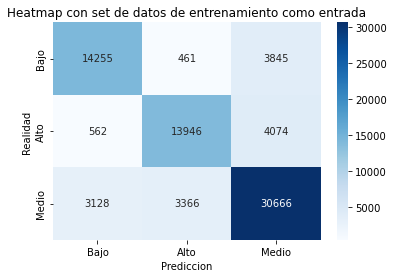

In [34]:
y_pred_train = arbol_predictor_randomcv.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')


Del heatmap anterior, podemos ver que nuestro modelo tiene una tendencia a clasificar de manera desbalanceada, ya que se ve una diferencia de metrica importante entre clases.  
A su vez, el modelo clasifica mejor aquellas viviendas cuyo tipo de precio es Medio.
Ahora vamos a ver como predice con nuestra entrada de test.

              precision    recall  f1-score   support

        Alto       0.66      0.63      0.65      4632
        Bajo       0.67      0.63      0.65      4705
       Medio       0.68      0.71      0.70      9239

    accuracy                           0.67     18576
   macro avg       0.67      0.66      0.66     18576
weighted avg       0.67      0.67      0.67     18576

F1-Score: 0.6721449040794651


Text(33.0, 0.5, 'Realidad')

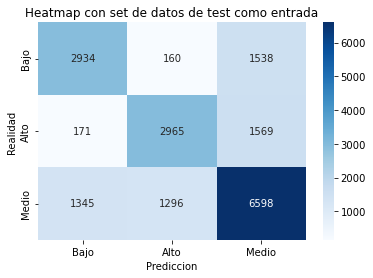

In [35]:
y_pred_test = arbol_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Podemos observar en este caso que para el dataset de entrada no se overfittea, y que a su vez la metrica F1 nos da parecida aunque un poco menor.  
A su vez, seguimos viendo una diferencia de metricas entre clases, donde se pondera un poco de mejor manera aquellas propiedades de tipo de precio Medio.  

Ahora vamos a ver que pasa con nuestra metrica si entrenamos el arbol con una gran cantidad de folds.

In [36]:
# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=50) 
 
#Creo árbol con los mejores hiperparámetros 
arbolcv=DecisionTreeClassifier(random_state= 42)

#Selecciono métrica F1-Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Hago CV
resultados = cross_validate(arbolcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True, n_jobs=-1)

#Selecciono el arbol con mejor performance
metricsCV=resultados['test_score']

In [37]:
metricsCV

array([0.70032612, 0.69936131, 0.67906236, 0.69059282, 0.70376963,
       0.70225499, 0.71390654, 0.70315118, 0.69385882, 0.69670738,
       0.68934278, 0.70161827, 0.69711026, 0.69942923, 0.70340935,
       0.70473134, 0.71285515, 0.70685883, 0.69541959, 0.70743708,
       0.71362379, 0.68732474, 0.69582159, 0.69382699, 0.72020541,
       0.70614515, 0.71176476, 0.7060305 , 0.70385976, 0.69148964,
       0.69521266, 0.72073533, 0.69532423, 0.72300238, 0.70819646,
       0.71789759, 0.70964082, 0.69688374, 0.71263135, 0.71400099,
       0.69535807, 0.7034367 , 0.70466727, 0.71396732, 0.71816118,
       0.71101885, 0.66930105, 0.7263012 , 0.73635196, 0.70673488])

c:\Users\iankl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Boxplot de F1 Score para CV'), Text(0.5, 0, 'F1 Score')]

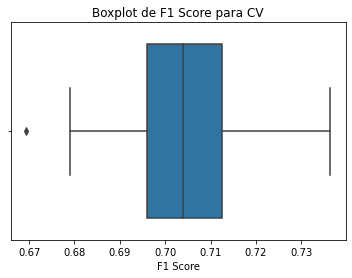

In [38]:
sns.boxplot(metricsCV).set(title="Boxplot de F1 Score para CV",xlabel='F1 Score')

Vemos que entrenar el arbol con muchisimos folds puede levantar la media de la metrica F1. Vamos a predecir con el árbol de mayor metrica.

              precision    recall  f1-score   support

        Alto       0.69      0.70      0.70      4632
        Bajo       0.68      0.68      0.68      4705
       Medio       0.73      0.71      0.72      9239

    accuracy                           0.70     18576
   macro avg       0.70      0.70      0.70     18576
weighted avg       0.70      0.70      0.70     18576

F1-Score: 0.7038775368622544


Text(33.0, 0.5, 'Realidad')

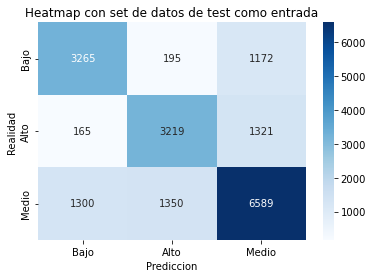

In [39]:
arbol_mejor_performance_cv=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
y_pred_test_cv = arbol_mejor_performance_cv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test_cv))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test_cv, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test_cv)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

De aca podemos concluir que para este modelo no hace mucha diferencia tener en cuenta mas folds respecto a el arbol planteado por defecto.  
A su vez, no se pudo optimizar los hiperparametros de aquellos que vienen por defecto, ya que nos dio un score menor.    
Observamos tambien que las metricas generalmente estan balanceadas, no hay una diferencia fuerte entre Precision y Recall para una misma clase.  
Para nuestro estudio el mejor modelo es aquel el cual deja crecer el arbol hasta que cada nodo sea puro, divide siempre en 2, cada hoja tiene una sola muestra y se tienen en cuenta todos los atributos.  
Vamos a graficar el mejor arbol obtenido por CrossValidation recortado.

In [40]:
plt.figure(figsize=(200,200))

tree_plot=tree.plot_tree(arbol_mejor_performance_cv,
                         max_depth=3,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=arbol_mejor_performance_cv.classes_)

plt.show(tree_plot)

Vamos a imprimir tambien los atributos mas importantes de nuestro arbol.

In [41]:
feat_imps = arbol_mejor_performance_cv.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,columnas)):
  if feat_imp>0.01:
    print('{}: {}'.format(feat,feat_imp))

barrio_Boedo: 0.010381158681883064
property_type_Casa: 0.011038540834390053
property_bedrooms: 0.01913147480483362
property_rooms: 0.029608564237526846
barrio_Pompeya: 0.03059730681036667
property_surface_covered: 0.15348994172202746
property_surface_total: 0.16171859784418827
longitud: 0.23343471316313727
latitud: 0.3044673920709941


Vemos que los parametros de latitud, longitud y los de superficies resultan ser los mas relevantes. Esto mismo se puede ver en el grafico, donde el nodo raiz divide por latitud <= -34,598.  
Si nos fijamos en el mapa, este valor divide lo que seria la mayoria de los barrios del Norte de CABA del resto.  
Ademas vemos que, a esta profundidad (3), el atributo longitud aparece en muchas ocasiones, lo cual confirma su importancia a la hora de clasificar.
Tambien podemos ver que si el barrio de la propiedad no es Puerto Madero, es de tipo de precio Medio, lo cual es logico, pero este es el unico caso donde se observa que un atributo del tipo barrio sea significativo.  
Esto se debe a que subdividir por latitud y longitud equivale a elegir barrios infinitamente mas chicos que los de los atributos.  


In [42]:
#Guardamos el mejor modelo de arbol de decision
arbol_mejor_performance = arbol_mejor_performance_cv
joblib.dump(arbol_mejor_performance, './Models/arbol_mejor_performance') 

['./Models/arbol_mejor_performance']

### Modelo 2: Random Forest

El Random Forest es un metodo basado en tener muchos arboles de decision mediocres y someterlos a votación para predecir.  
A modo de introducción, vamos a hacer una prediccion con un Random Forest que tenga los parametros por default.

In [43]:
rf_default = RandomForestClassifier(random_state= 42, n_jobs=-1)
rf_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Vamos a probarlo con el dataset de train y el dataset de test, utilizando como metrica la F1 Score.

              precision    recall  f1-score   support

        Alto       0.98      0.98      0.98     18561
        Bajo       0.98      0.97      0.98     18582
       Medio       0.98      0.98      0.98     37160

    accuracy                           0.98     74303
   macro avg       0.98      0.98      0.98     74303
weighted avg       0.98      0.98      0.98     74303

F1-Score: 0.9782367426995848


Text(33.0, 0.5, 'Realidad')

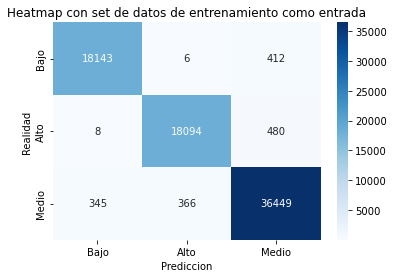

In [44]:
rf_default.fit(x_train,y_train)
y_pred_train = rf_default.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

              precision    recall  f1-score   support

        Alto       0.77      0.68      0.72      4632
        Bajo       0.77      0.70      0.73      4705
       Medio       0.73      0.80      0.76      9239

    accuracy                           0.75     18576
   macro avg       0.75      0.73      0.74     18576
weighted avg       0.75      0.75      0.74     18576

F1-Score: 0.7448661424256348


Text(33.0, 0.5, 'Realidad')

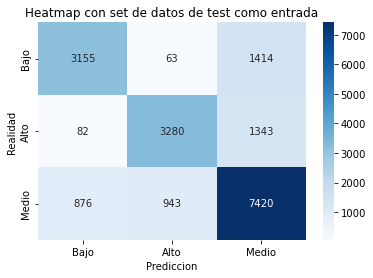

In [45]:
y_pred_test = rf_default.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Como en arboles de decision, se overfittea cuando se contrasta con los valores del dataset de entrenamiento.
Vemos que para predecir es bastante mejor que utilizar un arbol de decision, y ademas se sigue observando una ligera mejor prediccion para tipo de precio Medio.  
Tambien se observa una diferencia entre metricas, vemos que hay una mejor Precision para las clases Bajo y Alto, y un mejor Recall para la clase Medio, lo cual nos confirma que maximizar la metrica F1 es el camino a seguir para este modelo.  



De manera analoga al modelo anterior, vamos a buscar la mejor combinacion de hiperparametros utilizando K-fold Cross Validation y buscando los mismos con Random Search.  
Por defecto, vamos a dejar la cantidad de folds en 5, luego veremos si podemos mejorar la busqueda de parametros utilizando Grid Search.  
Los hiperparametros del arbol de decision a maximizar son:
+ N_Estimators: Es la cantidad de arboles que va a tener el bosque, vamos a tomar de 100 a 300 arboles.
+ Criterio: Es el parametro para medir la calidad de la clasificacion. Vamos a hacer que se decida entre Gini o Entropy porque Log Loss no lo conocemos.
+ Max Depth: Es el parametro que, si se lo define, limita la profundidad del arbol. Por defecto deja que el arbol se extienda hasta que sus hojas sean puras, pero esto claramente puede generar un arbol muy grande innecesariamente.
+ Min Samples Split: Es el parametro que define el numero minimo de muestras necesarias para distinguir un nodo interno por arbol. Vamos a hacer que pruebe entre valores bajos.
+ Min Samples Leaf: Es el parametro qe define la minima cantidad de muestras necesarias para un nodo hoja por arbol. Igual que el anterior, vamos a hacer que pruebe entre valores bajos.
+ Max Features: Es el parametro que define la cantidad de atributos que deben tenerse en cuenta al clasificar por cada arbol. Vamos a dejar que busque entre raiz(atributos totales) y log2(atributos totales)
+ Random State: Es el parametro que define la semilla del generador de numeros aleatorios. Vamos a dejarlo setearlo en 42.
+ Max Leaf Nodes: Es el parametro que define la cantidad maxima de nodos hoja por arbol. Por defecto no hay limite, asi que vamos a dejarlo asi.
+ CCP Alpha: Es un parametro que define la poda de sub arboles dentro del arbol de decision por arbol. Vamos a dejarlo en 0, que es como viene por defecto.
+ Bootstrap: Es un parametro que define si se va a aplicar bootstrapping a las muestras,. Por defecto no se hace bootstrapping, lo vamos a dejar asi.

La metrica a maximizar sera el F1 Score, para ser consistentes con lo que venimos haciendo.
Al ser una prediccion multiclase, tenemos que elegir como va a calcular el promedio para cada clase, en nuestro caso vamos a definirla como `weighted` debido a que nuestra entrada de clases esta desbalanceada (tenemos una porcion mucho mas grande de tipo de precio Medio que del resto).

In [46]:
#Cantidad de iteraciones
n = 20

#Conjunto de parámetros que queremos usar
params = {'criterion':['gini','entropy'],
            'max_features':['sqrt', 'log2'],   
            'min_samples_leaf': [1,2,3,5,7,10,15],               
            'min_samples_split':[2,4,6,8,10,12,14,16],
            'n_estimators':[100,200,300]
            }

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = RandomForestClassifier(n_jobs=-1) 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Random Search Cross Validation
randomcvRF = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state=42) 

randomcvRF.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 5, 7, 10,
                                                             15],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [47]:
print(randomcvRF.best_params_)
print(randomcvRF.best_score_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}
0.7203775864850033


Vemos que no obtenemos una mejoria resonante respecto del RF hecho por default.  
Vamos a setear un RF con los mejores parametros y vamos a predecir con ambos datasets.  

In [48]:
rf_predictor_randomcv=RandomForestClassifier(n_jobs=-1).set_params(**randomcvRF.best_params_)
rf_predictor_randomcv.fit(x_train,y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       n_estimators=200, n_jobs=-1)

              precision    recall  f1-score   support

        Alto       0.95      0.84      0.89     18561
        Bajo       0.93      0.83      0.88     18582
       Medio       0.86      0.96      0.90     37160

    accuracy                           0.89     74303
   macro avg       0.91      0.87      0.89     74303
weighted avg       0.90      0.89      0.89     74303

F1-Score: 0.8933049103402002


Text(33.0, 0.5, 'Realidad')

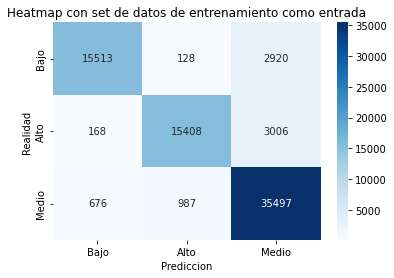

In [49]:

y_pred_train = rf_predictor_randomcv.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')


Vemos claramente que RF overfittea cuando la entrada es el dataset de entrenamiento.

              precision    recall  f1-score   support

        Alto       0.79      0.62      0.70      4632
        Bajo       0.79      0.65      0.71      4705
       Medio       0.70      0.84      0.76      9239

    accuracy                           0.74     18576
   macro avg       0.76      0.70      0.72     18576
weighted avg       0.75      0.74      0.73     18576

F1-Score: 0.7341859826177094


Text(33.0, 0.5, 'Realidad')

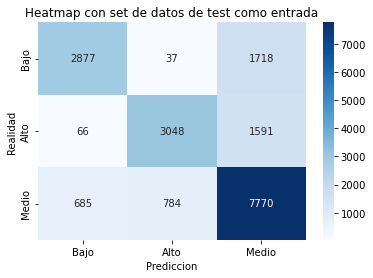

In [50]:
y_pred_test = rf_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Este ultimo grafico nos confirma que no conseguimos una mejora respecto del RF hecho por default.  
Vamos a ver si tomando muchos folds notamos algun cambio en la metrica

In [51]:
# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=20) 
 
#Creo árbol con los mejores hiperparámetros 
rf_cv=RandomForestClassifier(random_state= 42)

#Selecciono métrica F1-Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Hago CV
resultados = cross_validate(rf_cv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True, n_jobs=-1)

#Selecciono el arbol con mejor performance
metricsCV=resultados['test_score']

In [52]:
metricsCV

array([0.72634181, 0.73422672, 0.74709725, 0.739364  , 0.74428623,
       0.73119551, 0.73976915, 0.74086233, 0.73288307, 0.74463242,
       0.74378731, 0.73788132, 0.74200356, 0.74177215, 0.73747721,
       0.74346095, 0.72924087, 0.75146885, 0.73191186, 0.74679599])

c:\Users\iankl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Boxplot de F1 Score para CV'), Text(0.5, 0, 'F1 Score')]

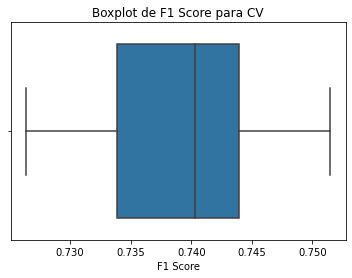

In [53]:
sns.boxplot(metricsCV).set(title="Boxplot de F1 Score para CV",xlabel='F1 Score')

              precision    recall  f1-score   support

        Alto       0.77      0.68      0.72      4632
        Bajo       0.76      0.69      0.73      4705
       Medio       0.73      0.80      0.76      9239

    accuracy                           0.74     18576
   macro avg       0.75      0.72      0.74     18576
weighted avg       0.75      0.74      0.74     18576

F1-Score: 0.7422169581799882


Text(33.0, 0.5, 'Realidad')

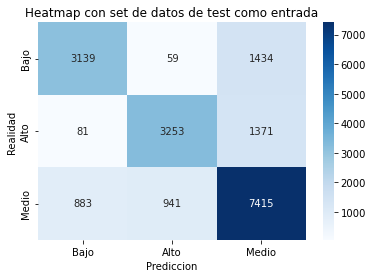

In [54]:
rf_mejor_performance_cv=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
y_pred_test_cv = rf_mejor_performance_cv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test_cv))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test_cv, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test_cv)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

De manera analoga al modelo 1, no conseguimos mejores hiperparametros ni aumentamos la calidad de las predicciones tomando mas folds.  
A modo de conclusion, podemos decir que RF es hasta ahora el mejor estimador que tenemos.
Vamos a graficar uno de los arboles del bosque y a ver sus parametros mas relevantes

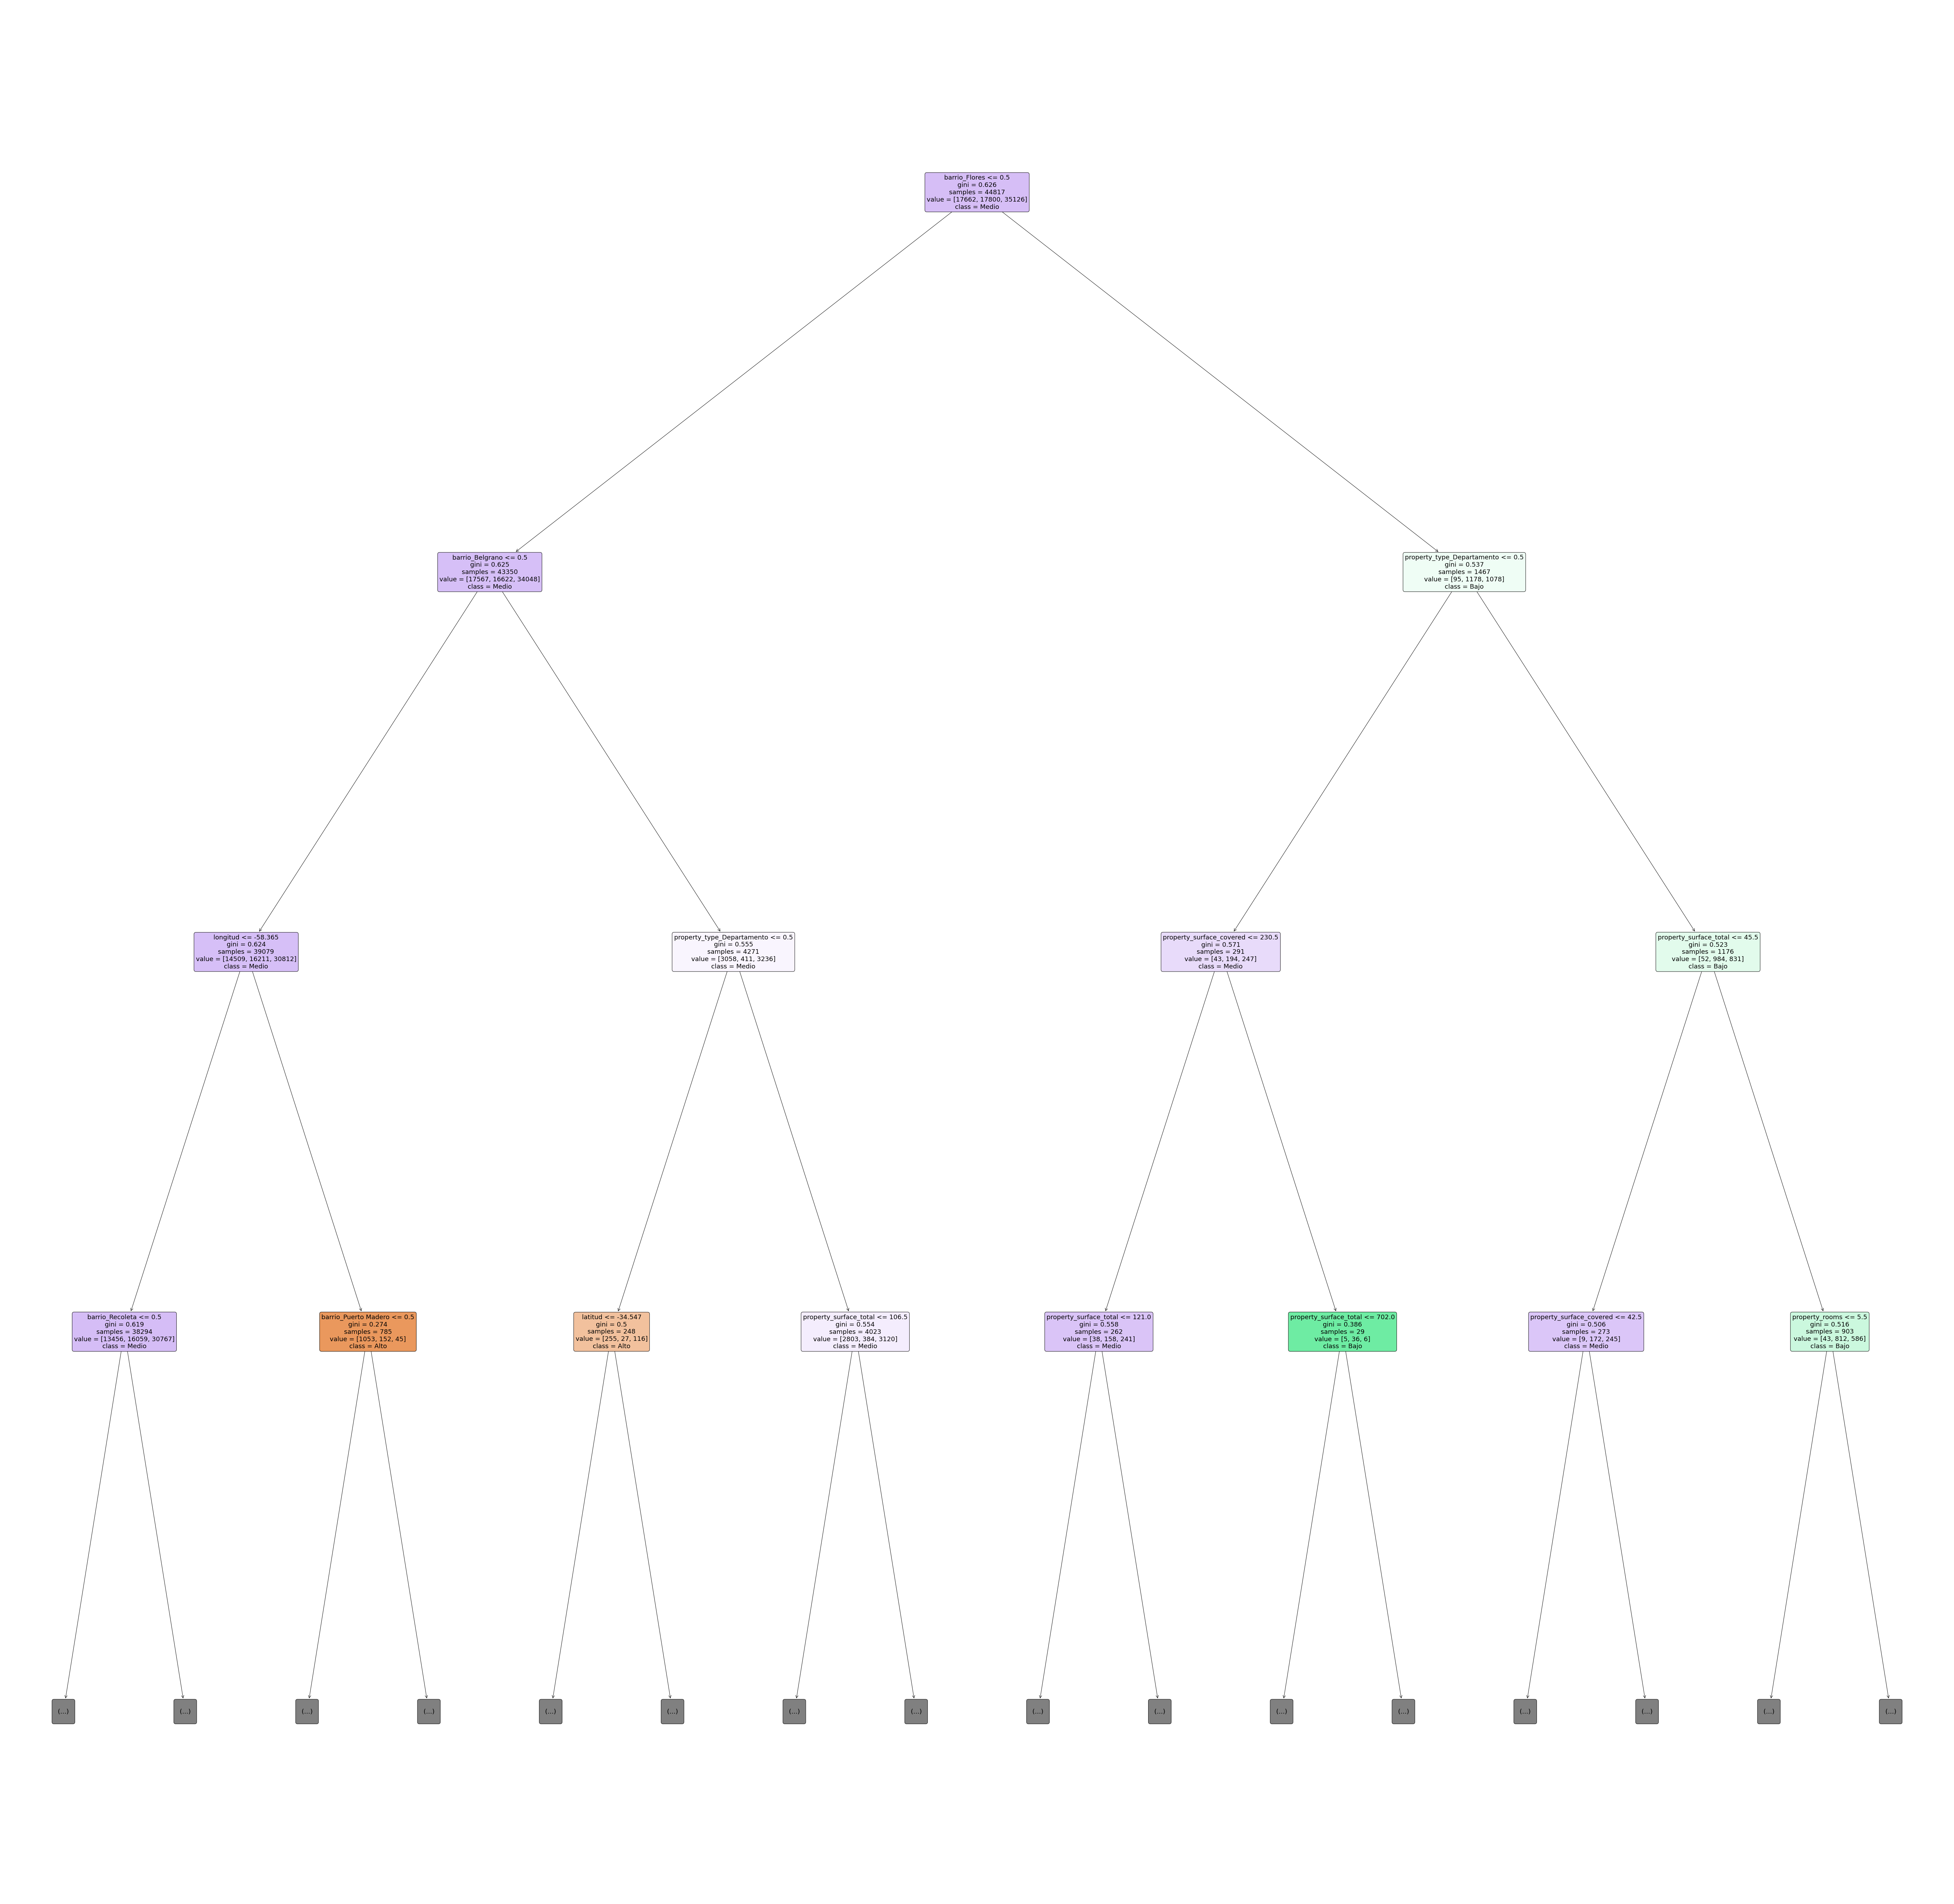

In [55]:
plt.figure(figsize=(100,100))

tree_plot=tree.plot_tree(rf_mejor_performance_cv.estimators_[50],
                         max_depth=3,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=rf_mejor_performance_cv.classes_)

plt.show(tree_plot)

In [56]:
feat_imps = rf_mejor_performance_cv.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,columnas)):
  if feat_imp>0.01:
    print('{}: {}'.format(feat,feat_imp))

barrio_Pompeya: 0.015075430907052564
barrio_Once: 0.01850349911041098
property_bedrooms: 0.01913004230754019
property_rooms: 0.027902814047269655
property_surface_covered: 0.15909277774586889
property_surface_total: 0.17570637207944678
longitud: 0.22192754454601352
latitud: 0.2638166620102782


De manera analoga al modelo 1, vemos que los parametros de latitud, longitud y los de superficies resultan ser los mas relevantes.  
Ademas, vemos que el nodo raiz del arbol elegido para graficar es un barrio. Es logico que suceda esto, ya que gran cantidad de estimadores comenzaran por un barrio, lo cual hace que una vez elegido, dividir por longitud y latitud resulte en una mejor prediccion.  

In [57]:
#Guardamos el mejor modelo de Random Forest
rf_mejor_performance = rf_mejor_performance_cv
joblib.dump(rf_mejor_performance, './Models/rf_mejor_performance') 

['./Models/rf_mejor_performance']

### Modelo 3: KNN

El algoritmo K-Nearest Neighbors es un metodo quebasicamente tiene en cuenta los atributos y los toma como una instacia, y luego evalua sus K vecinos para encontrar similitudes, intentando predecir un atributo en particular.  
Se puede utilizar tanto para clasificación o regresión.  
El algoritmo se basa en la idea de que los puntos de propiedades similares se encontrarán a poca distancia entre sí. Esta distancia no es necesariamente la euclideana, sino que se pueden utilizar diversos tipos de distancia.

De manera analoga a los modelos anteriores, vamos a tomar un clasificador por default y veremos que predicciones nos brinda.

In [58]:
#Crear el modelo
KNN_default = KNeighborsClassifier()

#vemos sus parámetros
KNN_default.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

              precision    recall  f1-score   support

        Alto       0.56      0.57      0.57      4632
        Bajo       0.60      0.55      0.57      4705
       Medio       0.64      0.66      0.65      9239

    accuracy                           0.61     18576
   macro avg       0.60      0.60      0.60     18576
weighted avg       0.61      0.61      0.61     18576

F1-Score: 0.6115728719677958


Text(33.0, 0.5, 'Realidad')

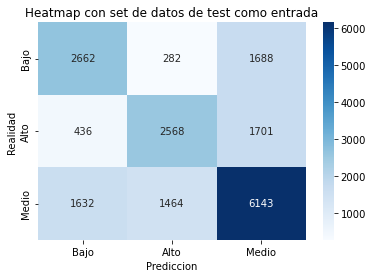

In [59]:
KNN_default.fit(x_train, y_train)
y_pred_test = KNN_default.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Vemos que este modelo predice de una manera mucho peor que los anteriores.  
Tambien observamos que, como en el metodo 1, las metricas estan balanceadas y que la clase Medio tiene mejores metricas respecto del resto.  
Vamos a ver que sucede con nuestra metrica si aumentamos la cantidad de vecinos.  

In [60]:
metrics = []

for n in range(1,50): 
    knn=KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    metrics.append((n, f1_score(y_test,y_pred, average='weighted')))

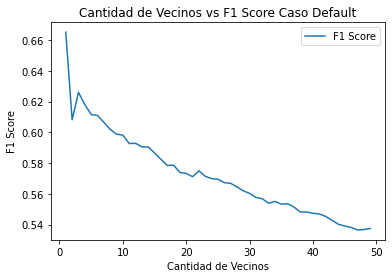

In [61]:
df_metrics = pd.DataFrame(metrics, columns=['Cantidad de Vecinos', "F1 Score"])

ax = df_metrics.plot(x="Cantidad de Vecinos", y="F1 Score", title = "Cantidad de Vecinos vs F1 Score Caso Default")
ax.set_ylabel("F1 Score")
ax.set_xlabel("Cantidad de Vecinos")
plt.show()

Vemos que nuestra metrica empeora a medida que tomamos mas vecinos, siendo la mejor opcion tomar pocos vecinos.  
Descartamos el hecho de tomar uno o dos vecinos, ya que podria terminar siendo clasificado con algun valor atipico que se nos haya escapado. De aca en adelante vamos a tomar como minimo 3 vecinos.  
De manera analoga al modelo anterior, vamos a buscar la mejor combinacion de hiperparametros utilizando K-fold Cross Validation y buscando los mismos con Random Search.  
Por defecto, vamos a dejar la cantidad de folds en 5, luego veremos si podemos mejorar la busqueda de parametros utilizando Grid Search.  
Los hiperparametros del arbol de decision a maximizar son:
+ N_Neighbors: Es la cantidad de vecinos que va a tomar el modelo para predecir. Vamos a tomar valores entre 3 y 20.
+ Weights: Es el parametro que va a definir si los pesos de los vecinos son iguales o no. Vamos a hacer que pruebe entre que tome pesos uniformes o que los pesos varien con la distancia de los vecinos.  
+ Algorithm: Es el parametro que define el algoritmo que define los K vecinos mas cercanos. En este caso vamos a hacer que pruebe entre todos los posibles.  
+ Metric: Es el parametro que define como se va a medir la distancia entre vecinos. Vamos a tomar un set de parametros que aplique para todos los algoritmos.  

In [62]:
#Cantidad de iteraciones
n = 20

#Conjunto de parámetros que queremos usar
params = {'n_neighbors':range(3,20), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
classifier = KNeighborsClassifier(n_jobs=-1) 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Random Search Cross Validation
randomcvKNN = RandomizedSearchCV(estimator=classifier,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state=42) 

randomcvKNN.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(3, 20),
                                        'weights': ['distance', 'uniform']},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [63]:
print(randomcvKNN.best_params_)
print(randomcvKNN.best_score_)

{'weights': 'distance', 'n_neighbors': 16, 'metric': 'manhattan', 'algorithm': 'ball_tree'}
0.66141644129852


In [64]:
KNN_predictor_randomcv= KNeighborsClassifier(n_jobs=-1).set_params(**randomcvKNN.best_params_)
KNN_predictor_randomcv.fit(x_train,y_train)

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=16, weights='distance')

              precision    recall  f1-score   support

        Alto       0.97      0.99      0.98     18561
        Bajo       0.97      0.99      0.98     18582
       Medio       0.99      0.97      0.98     37160

    accuracy                           0.98     74303
   macro avg       0.97      0.98      0.98     74303
weighted avg       0.98      0.98      0.98     74303

F1-Score: 0.9783586343416613


Text(33.0, 0.5, 'Realidad')

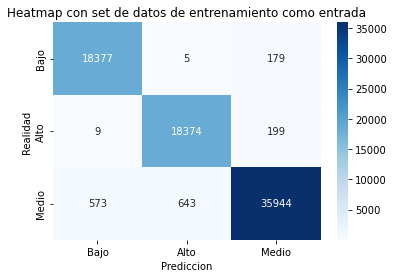

In [65]:
y_pred_train = KNN_predictor_randomcv.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

              precision    recall  f1-score   support

        Alto       0.66      0.64      0.65      4632
        Bajo       0.68      0.59      0.63      4705
       Medio       0.68      0.74      0.71      9239

    accuracy                           0.68     18576
   macro avg       0.67      0.66      0.66     18576
weighted avg       0.68      0.68      0.67     18576

F1-Score: 0.674845002332972


Text(33.0, 0.5, 'Realidad')

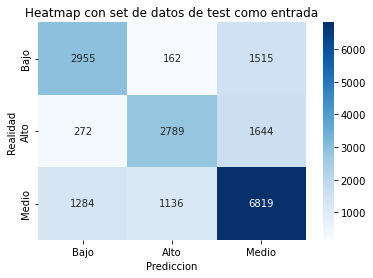

In [66]:
y_pred_test = KNN_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Observamos que mejoramos la metrica con la optimizacion de hiperparametros, aunque aun no es mejor que el del Modelo 2.  
Como en los casos anteriores, se clasifica un poco mejor las clases de tipo Medio, y que se overfittea cuando se contrasta con el dataset de entrenamiento.    
Como en RF, se observan que las metricas estan desbalanceadas, lo cual hace que optimizar F1 Score sea adecuado.  

Ahora vamos a ver que sucede si utilizamos muchos mas folds, y si contrastamos esto mismo con la cantidad de vecinos

In [67]:
k_range=range(3,20)

k_scores=[]

for k in k_range:
    
    knn=KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')
    scores=cross_val_score(knn,x_train,y_train,cv=20,scoring=scorer_fn)
    k_scores.append(scores.mean())

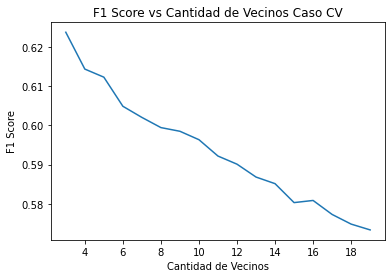

In [68]:
plt.plot(k_range, k_scores)
plt.xlabel('Cantidad de Vecinos')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Cantidad de Vecinos Caso CV')
plt.show()

Vemos que no mejoramos la metrica obtenida en el caso de la optimización de hiperparametros.  

In [69]:
#Guardamos el mejor modelo de KNN
knn_mejor_performance = KNN_predictor_randomcv
joblib.dump(knn_mejor_performance, './Models/knn_mejor_performance') 

['./Models/knn_mejor_performance']

#### A modo de conclusión, por lo mostrado podemos decir que el mejor modelo para clasificar es el de Random Forest.